<a href="https://colab.research.google.com/github/shaharbanu-123/FINAL-Project/blob/main/project_1-07_2025_full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Setup & Imports**

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



In [6]:
# CodeGrade Tag Init1
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **2. Load and Preprocess the Data**

In [7]:
# Load the csv
csv_loc = "/content/drive/MyDrive/cpcb_dly_aq_west_bengal-2010.csv"
df = pd.read_csv(csv_loc)

# Rename RSPM/PM10 column to PM10
df = df.rename(columns={'RSPM/PM10': 'PM10'})
# Rename Sampling Date to Date
df = df.rename(columns={'Sampling Date' : ' Date'})

df.head()



,Stn Code,Date,State,City/Town/Village/Area,Location of Monitoring Station,Agency,Type of Location,SO2,NO2,PM10,SPM
0,386,1/1/2010,West Bengal,Asansol,"Asansol Municipal Corporation, Asansol",West Bengal State Pollution Control Board,Industrial Area,10.0,80.1,252.000000,525.0
1,386,1/3/2010,West Bengal,Asansol,"Asansol Municipal Corporation, Asansol",West Bengal State Pollution Control Board,Industrial Area,10.6,84.1,248.000000,516.0
2,386,1/8/2010,West Bengal,Asansol,"Asansol Municipal Corporation, Asansol",West Bengal State Pollution Control Board,Industrial Area,9.8,85.2,253.666667,527.0
3,386,1/12/2010,West Bengal,Asansol,"Asansol Municipal Corporation, Asansol",West Bengal State Pollution Control Board,Industrial Area,9.2,77.6,255.333333,521.0
4,386,14-01-10,West Bengal,Asansol,"Asansol Municipal Corporation, Asansol",West Bengal State Pollution Control Board,Industrial Area,9.7,84.8,241.666667,511.0


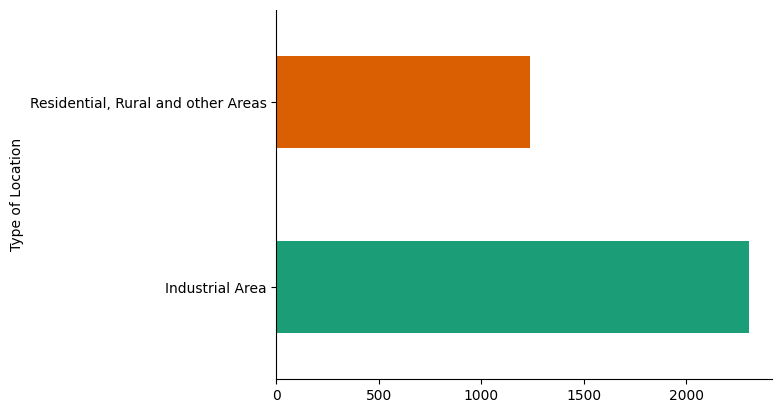

In [ ]:
# @title Type of Location

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('Type of Location').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

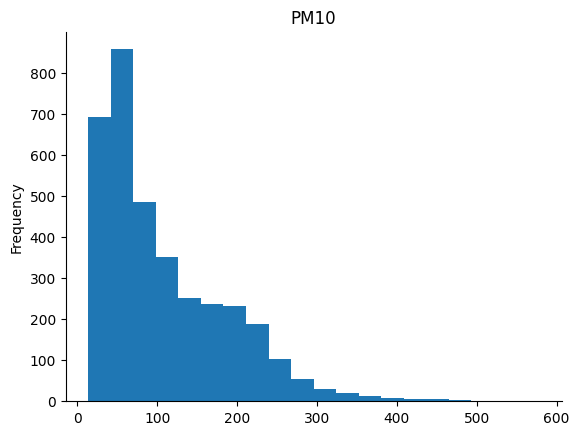

In [ ]:
# @title PM10

from matplotlib import pyplot as plt
df['PM10'].plot(kind='hist', bins=20, title='PM10')
plt.gca().spines[['top', 'right',]].set_visible(False)

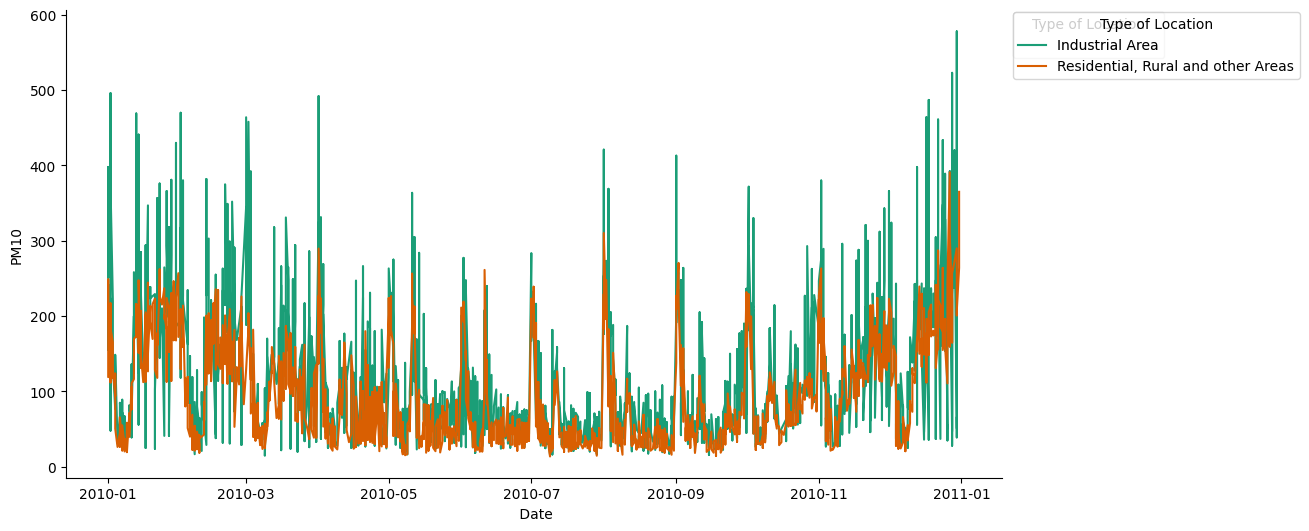

In [ ]:
# @title  Date vs PM10

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series[' Date']
  ys = series['PM10']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values(' Date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Type of Location')):
  _plot_series(series, series_name, i)
  fig.legend(title='Type of Location', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel(' Date')
_ = plt.ylabel('PM10')

In [8]:
# Parse date column and sort
df[' Date'] = pd.to_datetime(df[' Date'], format='mixed', dayfirst=True, errors='coerce')

df = df.sort_values(' Date')

# Filter PM2.5 values for a selected location
city_df = df[df['City/Town/Village/Area'] == 'Kolkata'][[' Date', 'PM10']].dropna()

# Resample daily average if needed
city_df = city_df.set_index( ' Date').resample('D').mean()

df.head()
city_df.head()

,PM10
Date,
2010-01-01,155.000000
2010-01-02,193.833333
2010-01-03,133.000000
2010-01-04,76.333333
2010-01-05,30.666667


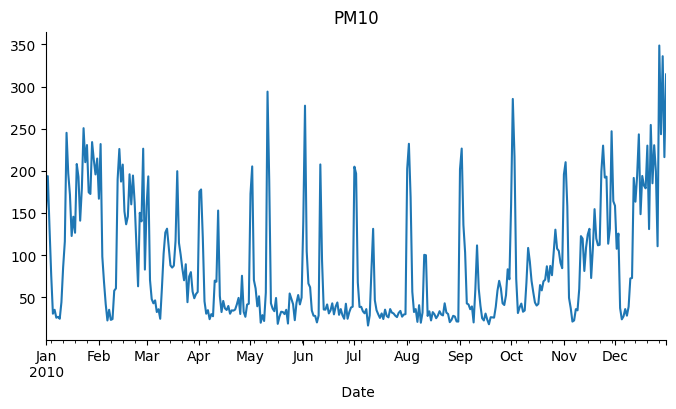

In [ ]:
# @title PM10

from matplotlib import pyplot as plt
city_df['PM10'].plot(kind='line', figsize=(8, 4), title='PM10')
plt.gca().spines[['top', 'right']].set_visible(False)

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Extract month for grouping
df['Day'] = df[' Date'].dt.day
df['Month'] = df[' Date'].dt.strftime('%b')
df['Month_Num'] = df[' Date'].dt.month  # to sort months later


In [36]:
# Group by month and day, then get average PM10
pivot_df = df.groupby(['Month_Num', 'Month', 'Day'])['PM10'].mean().reset_index()

# Pivot table: rows = day, columns = month
heatmap_data = pivot_df.pivot(index='Day', columns='Month', values='PM10')

# Sort months in calendar order
month_order = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
heatmap_data = heatmap_data[month_order]


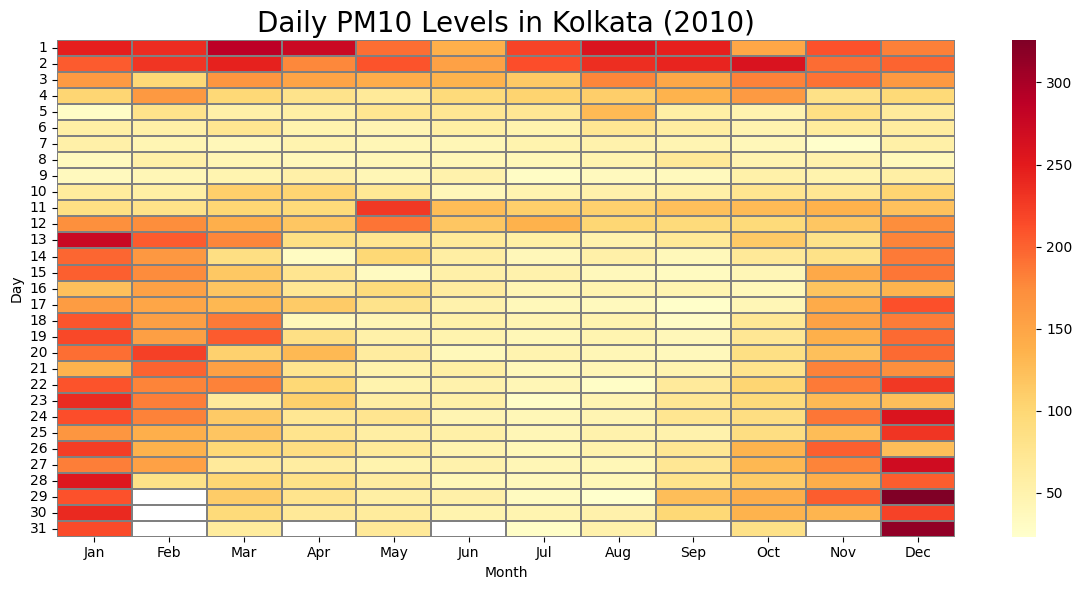

In [37]:
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap='YlOrRd', linewidths=0.3, linecolor='gray', annot=False)
plt.title('Daily PM10 Levels in Kolkata (2010)', fontsize=20)
plt.xlabel('Month')
plt.ylabel('Day')
plt.tight_layout()
plt.show()



# **3.ARIMA Forecasting**

In [38]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(city_df['PM10'])
print('ADF Statistic:', adf_test[0])
print('p-value:', adf_test[1])

ADF Statistic: -2.8018056343805826
p-value: 0.05801630858840748


The p-value: 0.05801630858840748 so it is greater than 0.05 .ie,d is >1 ,that means data is non stationary


# **Make it stationary**

In [39]:
city_df['PM10_diff'] = city_df['PM10'] - city_df['PM10'].shift(1)
city_df['PM10_diff'].dropna(inplace=True)


In [40]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(city_df['PM10_diff'].dropna())
print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")

ADF Statistic: -11.411511026675127
p-value: 7.231254795624079e-21


The p-value: 7.231254795624079e-21. This is very low . ie, d=1 ,now it is stationary

# **Select p and q using auto_arima**

➤ Autocorrelation Function (ACF) – helps select q (MA part)
Look for significant spikes in the ACF plot.

Example: If you see spikes at lag 1 and 2, consider q = 2.

➤ Partial Autocorrelation Function (PACF) – helps select p (AR part)
Look for significant PACF lags.


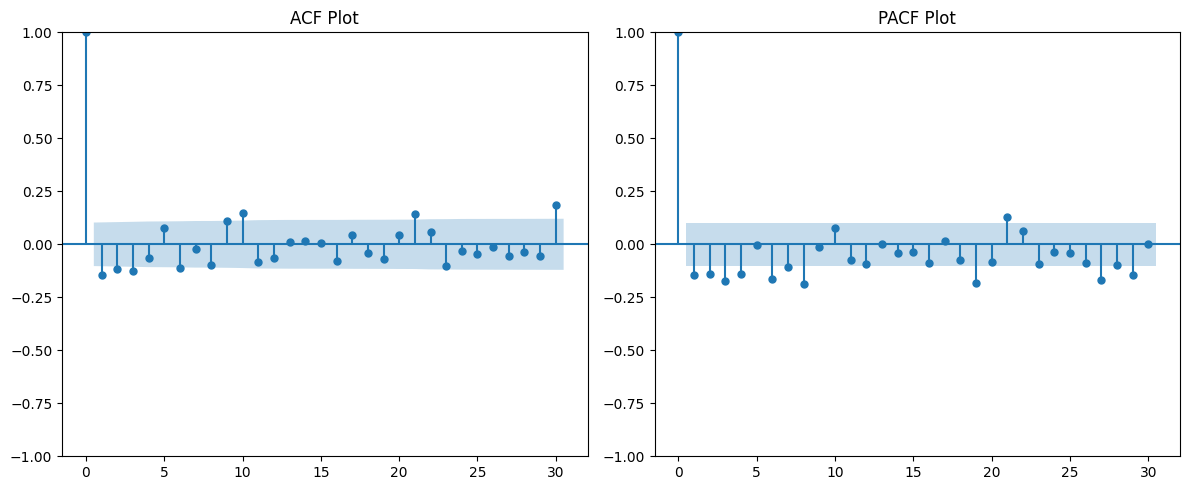

In [41]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(121)
plot_acf(city_df['PM10_diff'].dropna(), lags=30, ax=plt.gca())
plt.title('ACF Plot')

plt.subplot(122)
plot_pacf(city_df['PM10_diff'].dropna(), lags=30, ax=plt.gca(), method='ywm')
plt.title('PACF Plot')

plt.tight_layout()
plt.show()


* Identify MA order (q) from ACF plot
Look at where ACF cuts off (i.e., drops below the confidence interval quickly).

In my plot:

ACF has a strong spike at lag 1, then falls inside the shaded region (noise).

 So q = 1 is a good starting point.

* Identify AR order (p) from PACF plot
Look at where PACF cuts off.

In my plot:

PACF also shows a strong spike at lag 1, then drops off.

So p = 1 is a good candidate.

| Parameter | Plot Used | Rule                    | Estimated Value |
| --------- | --------- | ----------------------- | --------------- |
| **p**     | PACF      | Cuts off at 1           | 1               |
| **d**     | ADF test  | Stationary after 1 diff | 1               |
| **q**     | ACF       | Cuts off at 1           | 1               |


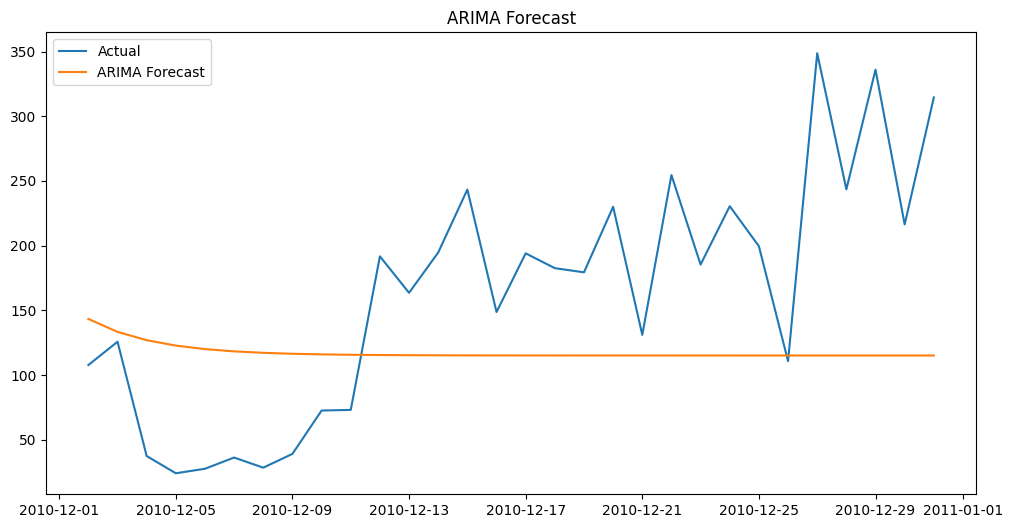

In [28]:
from statsmodels.tsa.arima.model import ARIMA

# Train-test split
train, test = city_df[:-30], city_df[-30:]

model = ARIMA(train['PM10'], order=(1, 1, 1 ))
model_fit = model.fit()
forecast = model_fit.forecast(steps=30)

# plot
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['PM10'].values, label='Actual')
plt.plot(test.index, forecast, label='ARIMA Forecast')
plt.legend()
plt.title('ARIMA Forecast')
plt.show()

ARIMA - RMSE: 104.43, MAE: 88.78, MAPE: 90.98%


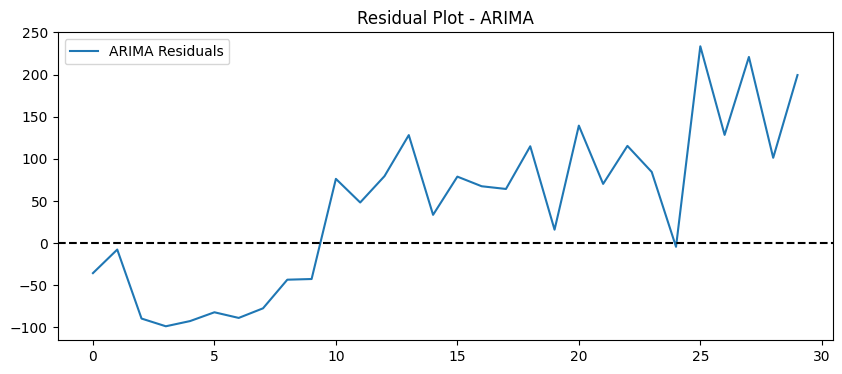

In [30]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

 #Evaluate forcast for ARIMA

def evaluate_forecast(true, pred, label='Model'):
    rmse = np.sqrt(mean_squared_error(true, pred))
    mae = mean_absolute_error(true, pred)
    mape = np.mean(np.abs((true - pred) / true)) * 100
    print(f"{label} - RMSE: {rmse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}%")
    return rmse, mae, mape
    #Plot Residual
def plot_residuals(true, pred, label='Model'):
    residuals = true.flatten() - pred.flatten()
    plt.figure(figsize=(10, 4))
    plt.plot(residuals, label=f'{label} Residuals')
    plt.axhline(0, linestyle='--', color='black')
    plt.title(f'Residual Plot - {label}')
    plt.legend()
    plt.show()

arima_rmse, arima_mae, arima_mape = evaluate_forecast(test['PM10'].values, forecast.values, 'ARIMA')
plot_residuals(test['PM10'].values, forecast.values, 'ARIMA')

In [31]:
#Camparison table

import pandas as pd

metrics_df = pd.DataFrame({
    'Model': ['ARIMA'],
    'RMSE': [arima_rmse],
    'MAE': [arima_mae],
    'MAPE (%)': [arima_mape]
})

metrics_df.set_index('Model', inplace=True)
metrics_df.style.background_gradient(cmap='RdYlGn_r').format("{:.2f}")


,RMSE,MAE,MAPE (%)
Model,,,
ARIMA,104.43,88.78,90.98
